### Choose a first-order system of your choice and perform the following task.
- (a) Write down the transfer function of the chosen system and state the input, output, manipulated,
and control variables.
- (b) Simulate the open-loop system.
- (c) Design a suitable controller for the chosen system.
- (d) Justify the choice of the controller.
- (e) Design the controller tuning parameters such that
• (A) System performance is acceptable (closed loop and rise time are acceptable).
• (B) The system exhibits high variability in PV with no sustained oscillations.
- (f) Introduce sufficient change in set-point, add sensor noise, and record data of OP / PV and SP.
- (g) Analyze the loop data using data-driven models and controller performance metrics, and use
these to distinguish between scenarios (A) and (B).
- (h) In the report, discuss the data analysis technique and its effectiveness.

In [5]:
! pip install numpy pandas matplotlib dataclasses control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 11.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.3 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [control]m1/2 [control]


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import control as ct
from dataclasses import dataclass # using this for getting decorator 

# System Definition — Production–Inventory Level Control System

### System name: Production–Inventory Level Control System

Transfer Function:

𝐺(𝑠) = 𝐾 / 𝜏𝑠 + 1
	
where
- K=1.0 (steady-state gain)
- 𝜏 =5.0 (time constant)

Input (Manipulated Variable): Production Rate (OP)

Output (Controlled Variable): Inventory Level (PV)

Setpoint (SP): Desired Inventory Level

Disturbance: Customer Demand (simulated with seasonal + random variations)

In [ ]:
# defining the simulation params 

K = 1.0          # steady-state gain (inventory sensitivity to order rate)
tau = 10.0       # time constant (represents production/lead-time delay)
dt = 0.5         # simulation time-step (units arbitrary)
T_total = 500.0  # total simulation time


Controller chosen: PI Controller (Proportional–Integral)

Transfer function:

𝐶(𝑠) = 𝐾𝑝 + 𝐾𝑖/𝑠		​

Implemented with ct.TransferFunction([Kp * tau_i, Kp],

- Justification : Inventory systems need steady-state error elimination (no long-term stock imbalance),
which a PI controller ensures while avoiding the noise amplification of a derivative term (hence no PID).

In [ ]:
def simulate_inventory_ct(Kp, Ki, noise_std=0.1, random_seed=None):
    """
    Simulate closed-loop production–inventory system
    Returns pandas DataFrame with time, SP, PV, OP, and Demand.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Continuous-time plant: G(s) = K / (tau*s + 1)
    Gs = ct.tf([K], [tau, 1])

    # PI controller: C(s) = Kp + Ki/s = (Kp*s + Ki)/s
    Cs = ct.tf([Kp, Ki], [1, 0])

    # Closed-loop transfer function (without disturbance)
    T_closed = ct.feedback(Cs * Gs, 1)

    # Simulation time
    t = np.arange(0, T_total + dt, dt)
    N = len(t)

    # Setpoint profile
    SP = np.ones(N) * 5.0
    SP[t >= 150.0] = 8.0
    SP[t >= 350.0] = 4.0

    # Demand (acts as disturbance): time-varying stochastic signal
    base_demand = 0.5
    season_amp = 0.2 * np.sin(2 * np.pi * t / 200.0)
    demand = np.clip(base_demand + season_amp + np.random.poisson(1.0, N) * 0.05, 0.0, None)

    # Response to setpoint (no disturbance)
    t_out, PV_sp = ct.forced_response(T_closed, T=t, U=SP)

    # Approximate disturbance by subtracting demand effect
    # Model disturbance as output deviation proportional to demand rate
    disturbance_effect = -0.6 * demand
    PV = PV_sp + disturbance_effect

    # Add sensor noise
    PV_meas = PV + np.random.normal(scale=noise_std, size=N)

    # Compute controller output (approx): OP = controller * error
    error = SP - PV_meas
    integral_error = np.cumsum(error) * dt
    OP = Kp * error + Ki * integral_error
    OP = np.clip(OP, 0.0, 5.0)

    df = pd.DataFrame({
        "time": t,
        "SP": SP,
        "PV": PV,
        "PV_meas": PV_meas,
        "OP": OP,
        "Demand": demand
    })
    return df

In [ ]:
def compute_metrics(df, dt):
    
    """ returns a metrics dict """
    PV = df["PV"].values
    OP = df["OP"].values
    D = df["Demand"].values
    SP = df["SP"].values
    t = df["time"].values

    service_level = np.mean(PV >= 0.0)
    stockout_volume = np.sum(np.clip(-PV, 0.0,None)) * dt

    stockout_fraction = np.mean(PV < 0.0)
    error = SP - PV
    IAE = np.trapz(np.abs(error), t)
    ISE = np.trapz(error**2, t)


    metrics = {
        "service_level": service_level,
        "stockout_volume": stockout_volume,
        "stockout_fraction": stockout_fraction,
        "IAE": IAE,
        "ISE": ISE,
        "PV_mean": np.mean(PV),
        "PV_std": np.std(PV),
        "OP_std": np.std(OP)
    }
    return metrics

ARX model (AutoRegressive with eXogenous input)

In [ ]:
def fit_arx_with_demand(df):
    """ return metrics """
    PV = df["PV"].values
    OP = df["OP"].values
    D = df["Demand"].values
    N = len(PV)

    X = np.column_stack([PV[:-1], OP[:-1], D[:-1], np.ones(N - 1)])
    y = PV[1:]


    theta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X @ theta

    rmse = np.sqrt(np.mean((y - y_pred)**2))
    ss_tot = np.sum((y - np.mean(y))**2)
    ss_res = np.sum((y - y_pred)**2)
    R2 = 1 - ss_res / ss_tot


    return {
            "theta": theta,
            "rmse": rmse,
            "R2": R2
        }

In [ ]:
def run_scenarios_ct():
    """ simulating 2 scenarios """
    scenarios = {
        "A": {"Kp": 0.6, "Ki": 0.05},
        "B": {"Kp": 1.6, "Ki": 0.02}
    }

    results = {"data": {}, "metrics": {}, "arx": {}}

    for name, params in scenarios.items():

        df = simulate_inventory_ct(**params, noise_std=0.1, random_seed=42)

        metrics = compute_metrics(df, dt)
        arx = fit_arx_with_demand(df)

        # results accumulation 
        results["data"][name] = df
        results["metrics"][name] = metrics
        results["arx"][name] = arx

        # saving to 2 csv
        df.to_csv(f"inventory_ct_scenario_{name}.csv", index=False)
        
        print(f"Saved inventory_ct_scenario_{name}.csv")

    return results

In [22]:
def plot_results_ct(df, title):
    """ plotting out """
    plt.figure(figsize=(10, 4))


    plt.plot(df["time"], df["SP"], label="SP")
    plt.plot(df["time"], df["PV"], label="PV")
    plt.plot(df["time"], df["OP"], label="OP")

    plt.plot(df["time"], df["Demand"], label="Demand", alpha=0.6)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Inventory Level / Production Rate / Demand")

    plt.legend()

    plt.grid(True)
    plt.tight_layout()

    plt.show()

Saved inventory_ct_scenario_A.csv
Saved inventory_ct_scenario_B.csv

Metrics Summary:

Scenario A:
  service_level: 0.9970
  stockout_volume: 0.2798
  stockout_fraction: 0.0030
  IAE: 369.8551
  ISE: 597.0417
  PV_mean: 5.3910
  PV_std: 1.8271
  OP_std: 0.1979

Scenario B:
  service_level: 0.9990
  stockout_volume: 0.1650
  stockout_fraction: 0.0010
  IAE: 533.5319
  ISE: 821.2048
  PV_mean: 5.0630
  PV_std: 1.5458
  OP_std: 0.1344

ARX Summary:
Scenario A: theta=[ 1.0011 -0.087   0.0913  0.3776], RMSE=0.0458, R2=0.9994
Scenario B: theta=[ 0.9936  0.0465  0.0661 -0.2322], RMSE=0.0543, R2=0.9988


/tmp/ipykernel_8250/2835967337.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  IAE = np.trapz(np.abs(error), t)
/tmp/ipykernel_8250/2835967337.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ISE = np.trapz(error**2, t)


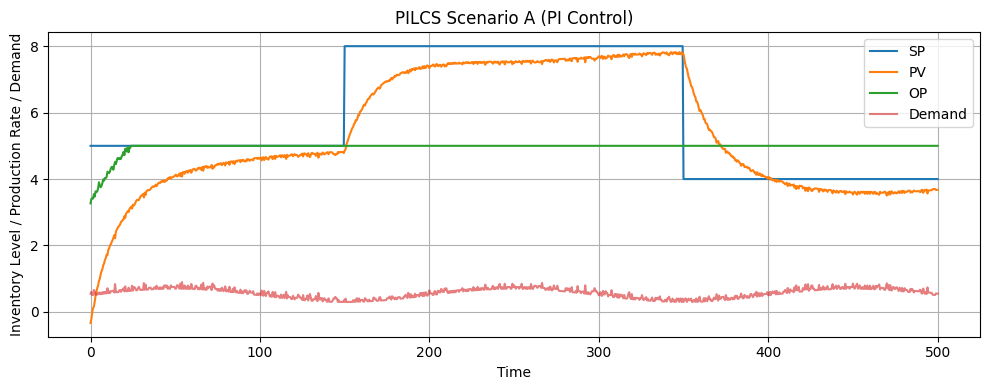

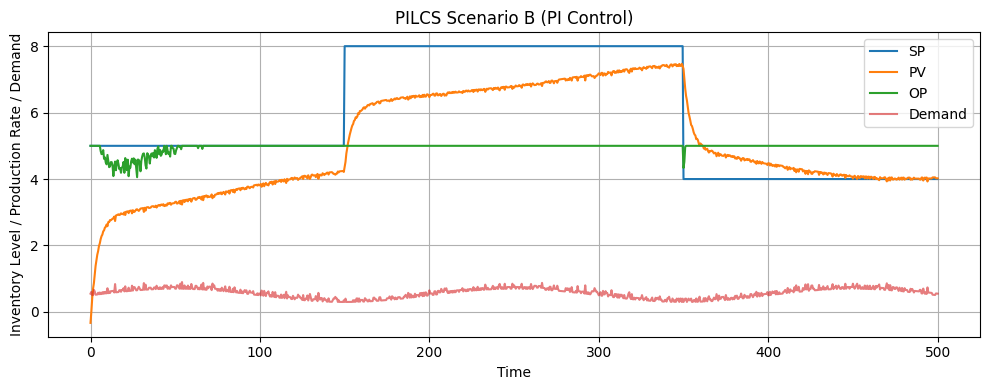

In [23]:
results = run_scenarios_ct()

# Display metrics
print("\nMetrics Summary:")
for name, metrics in results["metrics"].items():
    print(f"\nScenario {name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

# Display ARX fits
print("\nARX Summary:")
for name, arx in results["arx"].items():
    print(f"Scenario {name}: theta={np.round(arx['theta'],4)}, RMSE={arx['rmse']:.4f}, R2={arx['R2']:.4f}")

# Plot
for name, df in results["data"].items():
    plot_results_ct(df, f"PILCS Scenario {name} (PI Control)")